Notes: 
- Ranking the probability of patient's fall (e.g. high risk, etc.) might be enough instead of assigning individual patient's fall/non-fall value.
- Missing nursing data is not MCAR -> dummy variables for unknown values might be a good predictors

In [ ]:
# Installations

# %pip install autoviz
# %pip install miceforest
# %pip install prince
# %pip install gower

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from autoviz.AutoViz_Class import AutoViz_Class

%matplotlib inline


Imported v0.1.905. Please call AutoViz in this sequence:
    AV = AutoViz_Class()
    %matplotlib inline
    dfte = AV.AutoViz(filename, sep=',', depVar='', dfte=None, header=0, verbose=1, lowess=False,
               chart_format='svg',max_rows_analyzed=150000,max_cols_analyzed=30, save_plot_dir=None)


# Patient Fall Risk Assessment Project

## Section 1: Initial Exploration (EDA)

In this section, we:
- Provide a summary of the dataset
- Identify and handle outliers
- Assess missing data and determine strategies for imputation or removal
- Partition the data into training and testing sets


### 1. Data Overview

The dataset (`kip_sdm_syn.csv`) contains patient information split into two parts:
- **Medical Data:** Age, gender, diagnosis, procedure. This data is available for every patient.
- **Nursing Data:** Fall risk assessment and various risk factors, recorded only for patients at increased risk or exceeding a certain age threshold.

We begin by loading the dataset and examining its structure, (optionaly) combined with the insights provied by the Autoviz library.

As we can see, the dataset provides us with 45 features an 40000 entries.

In [3]:
# Load the dataset
path = "../data/kip_sdm_syn.csv"
df = pd.read_csv(path)

# Display the first few rows to understand the structure
print("Number of rows and columns:", df.shape)
df.head()

Number of rows and columns: (40000, 45)


,fallen,id,age,procedure,diagnosis,c_zriserh1,decubitus-admission,decubitus-at_the_moment,bed_mobility-impairment,bed_mobility-jones,bed_mobility-skin_condition,transfer-impairment,transfer,medical_items,medical_items-arm_or_leg_splint,medical_items-A_V_system,medical_items-plaster_or_neck_brace,medical_items-compression_stocking,medical_items-ventilation_mask,medical_items-O2_glasses,medical_items-orthesis,medical_items-prosthesis,medical_items-skin_condition_at_item_application,fall-last_12_month,fall-how_many_last_12_month,fall-while_stay,fall-while_transfer,walk-impairment,walk-jones,walk-balance_and_gait_impaired,walking_aid,excretions-impairment,excretions-incontinence,excretions-nykturie,cognition-impairment,cognition-disoriented_time,cognition-disoriented_location,cognition-disoriented_own_person,cognition-agitated,cognition-confused,psychotropic_or_sedatives_drugs,decubitus-risk,fall-risk,diseases,sex
0,False,179020,39,0,S250,False,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,2,False,False,False,False,False,NaN,False,False,False,False,False,False,NaN,NaN,False,female
1,False,112009,29,0,M418,False,False,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,False,NaN,False,False,NaN,False,False,NaN,False,False,False,False,False,False,NaN,NaN,NaN,male
2,False,54403,29,9-26,S910,False,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,False,NaN,False,False,NaN,False,False,NaN,False,False,False,False,False,NaN,NaN,0,NaN,female
3,False,13054,64,8-77,M400,True,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,False,False,NaN,False,False,True,True,False,NaN,False,False,False,False,False,False,0,0,False,male
4,False,45770,89,8-93,K630,False,NaN,False,NaN,NaN,NaN,NaN,2,NaN,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,NaN,False,False,NaN,False,False,False,False,False,False,NaN,NaN,NaN,male


In [4]:
# List all variable names and their data types
print("\nVariable names and their data types:")
print(df.dtypes)  # Displays column names with their data types


Variable names and their data types:
fallen                                                 bool
id                                                    int64
age                                                   int64
procedure                                            object
diagnosis                                            object
c_zriserh1                                             bool
decubitus-admission                                  object
decubitus-at_the_moment                              object
bed_mobility-impairment                              object
bed_mobility-jones                                   object
bed_mobility-skin_condition                          object
transfer-impairment                                  object
transfer                                             object
medical_items                                        object
medical_items-arm_or_leg_splint                        bool
medical_items-A_V_system                               bool
me

In [5]:
print("Column Names:", df.columns.tolist())

Column Names: ['fallen', 'id', 'age', 'procedure', 'diagnosis', 'c_zriserh1', 'decubitus-admission', 'decubitus-at_the_moment', 'bed_mobility-impairment', 'bed_mobility-jones', 'bed_mobility-skin_condition', 'transfer-impairment', 'transfer', 'medical_items', 'medical_items-arm_or_leg_splint', 'medical_items-A_V_system', 'medical_items-plaster_or_neck_brace', 'medical_items-compression_stocking', 'medical_items-ventilation_mask', 'medical_items-O2_glasses', 'medical_items-orthesis', 'medical_items-prosthesis', 'medical_items-skin_condition_at_item_application', 'fall-last_12_month', 'fall-how_many_last_12_month', 'fall-while_stay', 'fall-while_transfer', 'walk-impairment', 'walk-jones', 'walk-balance_and_gait_impaired', 'walking_aid', 'excretions-impairment', 'excretions-incontinence', 'excretions-nykturie', 'cognition-impairment', 'cognition-disoriented_time', 'cognition-disoriented_location', 'cognition-disoriented_own_person', 'cognition-agitated', 'cognition-confused', 'psychotropi

In [6]:
# Optional call to Autoviz for early exploration. Combine with your own instpecions.

# AV = AutoViz_Class()
# %matplotlib inline
# dfte = AV.AutoViz(df, sep=',', depVar='', dfte=None, header=0, verbose=1, lowess=False, chart_format='svg',max_rows_analyzed=150000,max_cols_analyzed=30, save_plot_dir=None)

In [7]:
###############################################################################
# 1. IDENTIFY THE TARGET AND DROP 'id'
###############################################################################
# 'fallen' is the target: "Ist der Patient gestürzt?" (logical => True/False).
# 'id' is just an identifier, so typically we don't use it for modeling.

if "id" in df.columns:
    # Keep 'id' in the dataframe for reference if needed, but do not model with it
    pass
	# df.drop(columns=["id"], inplace=True)

if "fallen" not in df.columns:
    raise ValueError("Target column 'fallen' not found in dataset. Please verify.")

In [8]:
###############################################################################
# 2. UNDERSTANDING AND CATEGORIZING EACH FEATURES
###############################################################################
# Upon examination, some features are recognized automatically as `object`.
# We did further inspection to determine if the data types are properly assigned.
# We determined the features that should be encoded as `bool` and convert them accoringly.

bool_vars = [
    "c_zriserh1",
    "decubitus-admission",
    "decubitus-at_the_moment",
    "bed_mobility-impairment",
    "bed_mobility-skin_condition",
    "transfer-impairment",
    "medical_items",
    "medical_items-skin_condition_at_item_application",
    "fall-last_12_month",
    "fall-while_stay",
    "fall-while_transfer",
    "walk-impairment",
    "excretions-impairment",
    "cognition-impairment",
    "psychotropic_or_sedatives_drugs",
    "diseases",
]

df[bool_vars] = df[bool_vars].astype("boolean")

df.dtypes

fallen                                                 bool
id                                                    int64
age                                                   int64
procedure                                            object
diagnosis                                            object
c_zriserh1                                          boolean
decubitus-admission                                 boolean
decubitus-at_the_moment                             boolean
bed_mobility-impairment                             boolean
bed_mobility-jones                                   object
bed_mobility-skin_condition                         boolean
transfer-impairment                                 boolean
transfer                                             object
medical_items                                       boolean
medical_items-arm_or_leg_splint                        bool
medical_items-A_V_system                               bool
medical_items-plaster_or_neck_brace     

In [9]:
###############################################################################
# 2. DOMAIN-SPECIFIC NOTES AND ACTIONS FOR EACH COLUMN
###############################################################################
# From the provided explanations, we have the following categories:
#   - Columns with 0 missing values (fully recorded).
#   - Logical columns with high missingness => means "not assessed" or "unknown".
#   - Jones score columns (character) that might hold numeric or ordinal values.
#   - 'decubitus-risk' and 'fall-risk' (character) with values {0, +, ++}
#   - 'c_zriserh1' is undocumented => decide whether to keep or drop.

# 3.1 Decide how to handle c_zriserh1 (logical, 0 missing, not documented).
#     If truly no documentation, consider dropping it. Otherwise, keep for potential
#     exploratory analysis. Here, we'll drop it for clarity.
# if "c_zriserh1" in df.columns:
#     df.drop(columns=["c_zriserh1"], inplace=True)


# 3.2 Convert 'decubitus-risk' and 'fall-risk' from {0, +, ++} to ordinal numeric
#     For example: 0 -> 0, + -> 1, ++ -> 2. If these are truly ordinal risk levels,
#     it helps to store them numerically.
risk_mapping = {"0": 0, "+": 1, "++": 2}

if "decubitus-risk" in df.columns:
    df["decubitus-risk"] = df["decubitus-risk"].map(risk_mapping).astype("Int64")

if "fall-risk" in df.columns:
    df["fall-risk"] = df["fall-risk"].map(risk_mapping).astype("Int64")


# 3.3 Convert 'sex' if it’s M/F (or other categories). If it’s just "M"/"W", you can
#     keep it as is or do a binary encoding. For demonstration, let's do a simple map:
sex_map = {"male": 0, "female": 1}
if "sex" in df.columns:
    df["sex"] = df["sex"].map(sex_map).astype("Int64")

In [10]:
print("Unique values and their counts for 'decubitus-risk':")
print(df['decubitus-risk'].value_counts(dropna=False))

Unique values and their counts for 'decubitus-risk':
decubitus-risk
<NA>    28511
0        8686
1        2193
2         610
Name: count, dtype: Int64


In [11]:
print("Unique values and their counts for 'sex':")
print(df['sex'].value_counts(dropna=False))

Unique values and their counts for 'sex':
sex
1    21371
0    18629
Name: count, dtype: Int64


In [12]:
# Initialize empty lists for each category
target = 'fallen'
numerical_vars = ['age', 'fall-how_many_last_12_month', 'decubitus-risk', 'fall-risk']
categorical_vars = ['procedure', 'diagnosis', 'bed_mobility-jones', 'transfer', 'walk-jones', 'sex']
ordinal_vars = []
bool_vars = ['c_zriserh1', 'decubitus-admission', 'decubitus-at_the_moment', 'bed_mobility-impairment', 'bed_mobility-skin_condition', 'transfer-impairment', 'medical_items', 'medical_items-arm_or_leg_splint', 'medical_items-A_V_system', 'medical_items-plaster_or_neck_brace', 'medical_items-compression_stocking', 'medical_items-ventilation_mask', 'medical_items-O2_glasses', 'medical_items-orthesis', 'medical_items-prosthesis', 'medical_items-skin_condition_at_item_application', 'fall-last_12_month', 'fall-while_stay', 'fall-while_transfer', 'walk-impairment', 'walk-balance_and_gait_impaired', 'walking_aid', 'excretions-impairment', 'excretions-incontinence', 'excretions-nykturie', 'cognition-impairment', 'cognition-disoriented_time', 'cognition-disoriented_location', 'cognition-disoriented_own_person', 'cognition-agitated', 'cognition-confused', 'psychotropic_or_sedatives_drugs', 'diseases']
id_vars = ['id']

# Print categorized variables
print("Numerical variables:", numerical_vars)
print("Categorical variables:", categorical_vars)
print("Ordinal variables:", ordinal_vars)
print("Boolean variables:", bool_vars)
print("ID variables:", id_vars)

# Check if all columns are categorized and there are no duplicates
all_categorized_columns = set(numerical_vars + categorical_vars + ordinal_vars + bool_vars + id_vars)
all_columns = set(df.columns)

# Find missing columns
missing_columns = all_columns - all_categorized_columns
if missing_columns:
	print("\nMissing columns that are not categorized:", missing_columns)
else:
	print("\nAll columns are categorized.")

# Find duplicate columns
duplicate_columns = [col for col in all_categorized_columns if list(all_categorized_columns).count(col) > 1]
if duplicate_columns:
	print("\nDuplicate columns found in categories:", duplicate_columns)
else:
	print("\nNo duplicate columns in categories.")

print(f'\n\nNumber of columns: {len(numerical_vars) + len(categorical_vars) + len(ordinal_vars) + len(bool_vars) + len(id_vars) + 1}')

Numerical variables: ['age', 'fall-how_many_last_12_month', 'decubitus-risk', 'fall-risk']
Categorical variables: ['procedure', 'diagnosis', 'bed_mobility-jones', 'transfer', 'walk-jones', 'sex']
Ordinal variables: []
Boolean variables: ['c_zriserh1', 'decubitus-admission', 'decubitus-at_the_moment', 'bed_mobility-impairment', 'bed_mobility-skin_condition', 'transfer-impairment', 'medical_items', 'medical_items-arm_or_leg_splint', 'medical_items-A_V_system', 'medical_items-plaster_or_neck_brace', 'medical_items-compression_stocking', 'medical_items-ventilation_mask', 'medical_items-O2_glasses', 'medical_items-orthesis', 'medical_items-prosthesis', 'medical_items-skin_condition_at_item_application', 'fall-last_12_month', 'fall-while_stay', 'fall-while_transfer', 'walk-impairment', 'walk-balance_and_gait_impaired', 'walking_aid', 'excretions-impairment', 'excretions-incontinence', 'excretions-nykturie', 'cognition-impairment', 'cognition-disoriented_time', 'cognition-disoriented_location

In [13]:
###############################################################################
# 3. CHECK NA VALUES
###############################################################################
# Check if any of the boolean variables contain NA values

# Print the number of NA values for each column
na_count_per_column = df.isna().sum()

# Calculate and print the percentage of NA values for each column
na_percentage_per_column = (na_count_per_column / len(df)) * 100


# Combine the number of NA values and their percentages into a DataFrame
na_summary = pd.DataFrame({
	'NA Count': na_count_per_column,
	'NA Percentage': na_percentage_per_column
})

# Print the summary
print(na_summary)

                                                  NA Count  NA Percentage
fallen                                                  0       0.0000   
id                                                      0       0.0000   
age                                                     0       0.0000   
procedure                                               0       0.0000   
diagnosis                                               0       0.0000   
c_zriserh1                                              0       0.0000   
decubitus-admission                                 30601      76.5025   
decubitus-at_the_moment                             30401      76.0025   
bed_mobility-impairment                             28872      72.1800   
bed_mobility-jones                                  37593      93.9825   
bed_mobility-skin_condition                         38447      96.1175   
transfer-impairment                                 28588      71.4700   
transfer                              

In [14]:
###############################################################################
# 3. CHECK UNIQUE VALUES
###############################################################################
# For each variable, check the number of unique values to determine if it is categorical, ordinal, or boolean.

unique_counts = df.nunique()
print(unique_counts)

fallen                                                  2
id                                                  38226
age                                                    84
procedure                                             209
diagnosis                                            3345
c_zriserh1                                              2
decubitus-admission                                     1
decubitus-at_the_moment                                 2
bed_mobility-impairment                                 2
bed_mobility-jones                                      5
bed_mobility-skin_condition                             2
transfer-impairment                                     2
transfer                                                5
medical_items                                           2
medical_items-arm_or_leg_splint                         2
medical_items-A_V_system                                1
medical_items-plaster_or_neck_brace                     2
medical_items-

## STATISTICS AND VARIANCE

In [15]:
# Inspect statistics for numerical variables
print("Statistics for numerical variables:")
numerical_stats = df[numerical_vars].describe().T  # Transpose for better readability
numerical_stats["variance"] = df[numerical_vars].var()  # Add variance column
print(numerical_stats)

Statistics for numerical variables:
                             count      mean      std      min   25%   50%   \
age                          40000.0     57.66  19.124127  19.0  39.0  59.0   
fall-how_many_last_12_month   1400.0  1.754659    1.54334   1.0   1.0   1.0   
decubitus-risk               11489.0  0.297067   0.561279   0.0   0.0   0.0   
fall-risk                    12328.0  0.330873   0.503365   0.0   0.0   0.0   

                             75%   max     variance   
age                          74.0  104.0  365.732243  
fall-how_many_last_12_month   1.0    5.0    2.381899  
decubitus-risk                0.0    2.0    0.315034  
fall-risk                     1.0    2.0    0.253376  


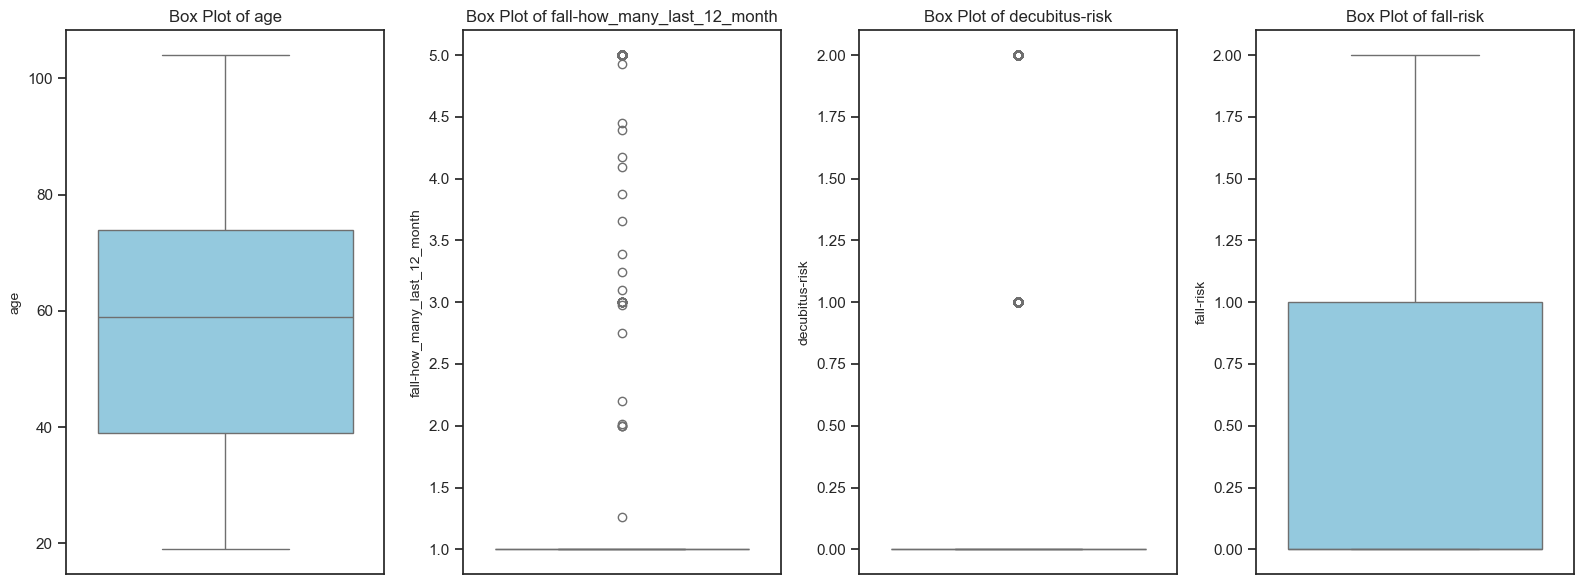

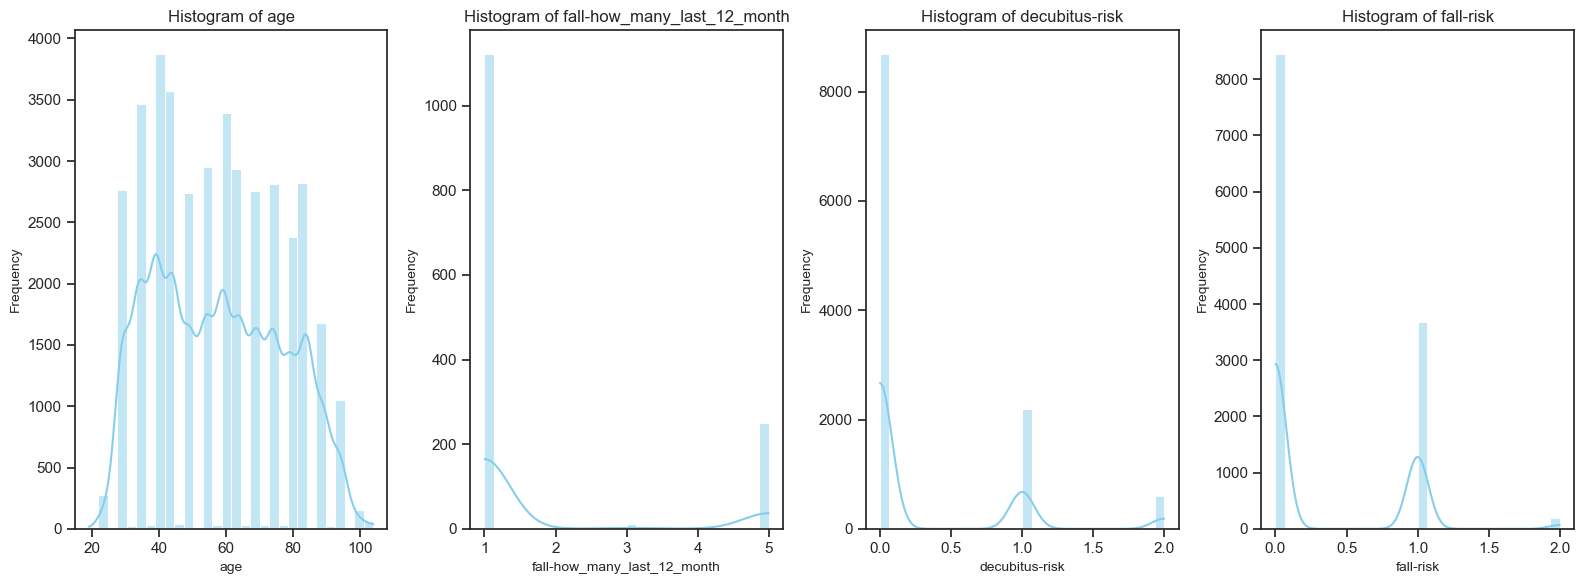

In [16]:
# Create side-by-side box plots for numerical variables
plt.figure(figsize=(16, 6))  # Adjust the figure size for better visualization

# Loop through numerical variables and create subplots
for i, col in enumerate(numerical_vars):
	plt.subplot(1, len(numerical_vars), i + 1)  # Create subplots in a single row
	sns.boxplot(y=df[col], color='skyblue')  # Use a consistent color for all plots
	plt.title(f'Box Plot of {col}', fontsize=12)  # Add title
	plt.ylabel(col, fontsize=10)  # Add y-axis label
	plt.xlabel('')  # Remove x-axis label for cleaner look
	plt.xticks([])  # Remove x-axis ticks for cleaner look

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

# Create histograms for numerical variables
plt.figure(figsize=(16, 6))  # Adjust the figure size for better visualization

# Loop through numerical variables and create subplots
for i, col in enumerate(numerical_vars):
	plt.subplot(1, len(numerical_vars), i + 1)  # Create subplots in a single row
	sns.histplot(df[col], kde=True, color='skyblue', bins=30)  # Histogram with KDE overlay
	plt.title(f'Histogram of {col}', fontsize=12)  # Add title
	plt.xlabel(col, fontsize=10)  # Add x-axis label
	plt.ylabel('Frequency', fontsize=10)  # Add y-axis label

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

## HANDLING MISSING DATA

### NUMERICAL VARIABLES

#### SINGLE IMPUTATION


##### 🧾 Imputation Strategy Summary

| Variable                        | Data Type              | Chosen Method | Reason                                                                 |
|---------------------------------|------------------------|----------------|------------------------------------------------------------------------|
| `age`                           | Numerical              | —              | No missing values — imputation not needed.                            |
| `fall-how_many_last_12_month`   | Discrete count         | **Median (1)** | Skewed distribution; median avoids fractional imputation (mean = 1.75). |
| `decubitus-risk`               | Categorical (ordinal)  | **Mode (0)**   | Most values are 0; small integer range (0–2); avoid mean (0.297).     |
| `fall-risk`                    | Categorical (ordinal)  | **Mode (0)**   | Strongly skewed to 0; mean (0.33) not compatible with integer dtype.  |


In [17]:

df_before = df.copy()

# Fix by rounding and converting to integer
df['fall-how_many_last_12_month'] = df['fall-how_many_last_12_month'].round().astype('Int64')
df['fall-how_many_last_12_month'] = df['fall-how_many_last_12_month'].fillna(
    df['fall-how_many_last_12_month'].median()
)

df['decubitus-risk'] = df['decubitus-risk'].fillna(df['decubitus-risk'].mode()[0])

df['fall-risk'] = df['fall-risk'].fillna(df['fall-risk'].mode()[0])

print("Number of missing values after single imputation: ")
print(df[numerical_vars].isnull().sum())
print("\nFall-risk mode:", df['fall-risk'].mode()[0])
print("Fall-how-many-last-12-month median:", df['fall-how_many_last_12_month'].median())
print("Decubitus-risk mode:", df['decubitus-risk'].mode()[0])


Number of missing values after single imputation: 
age                            0
fall-how_many_last_12_month    0
decubitus-risk                 0
fall-risk                      0
dtype: int64

Fall-risk mode: 0
Fall-how-many-last-12-month median: 1.0
Decubitus-risk mode: 0


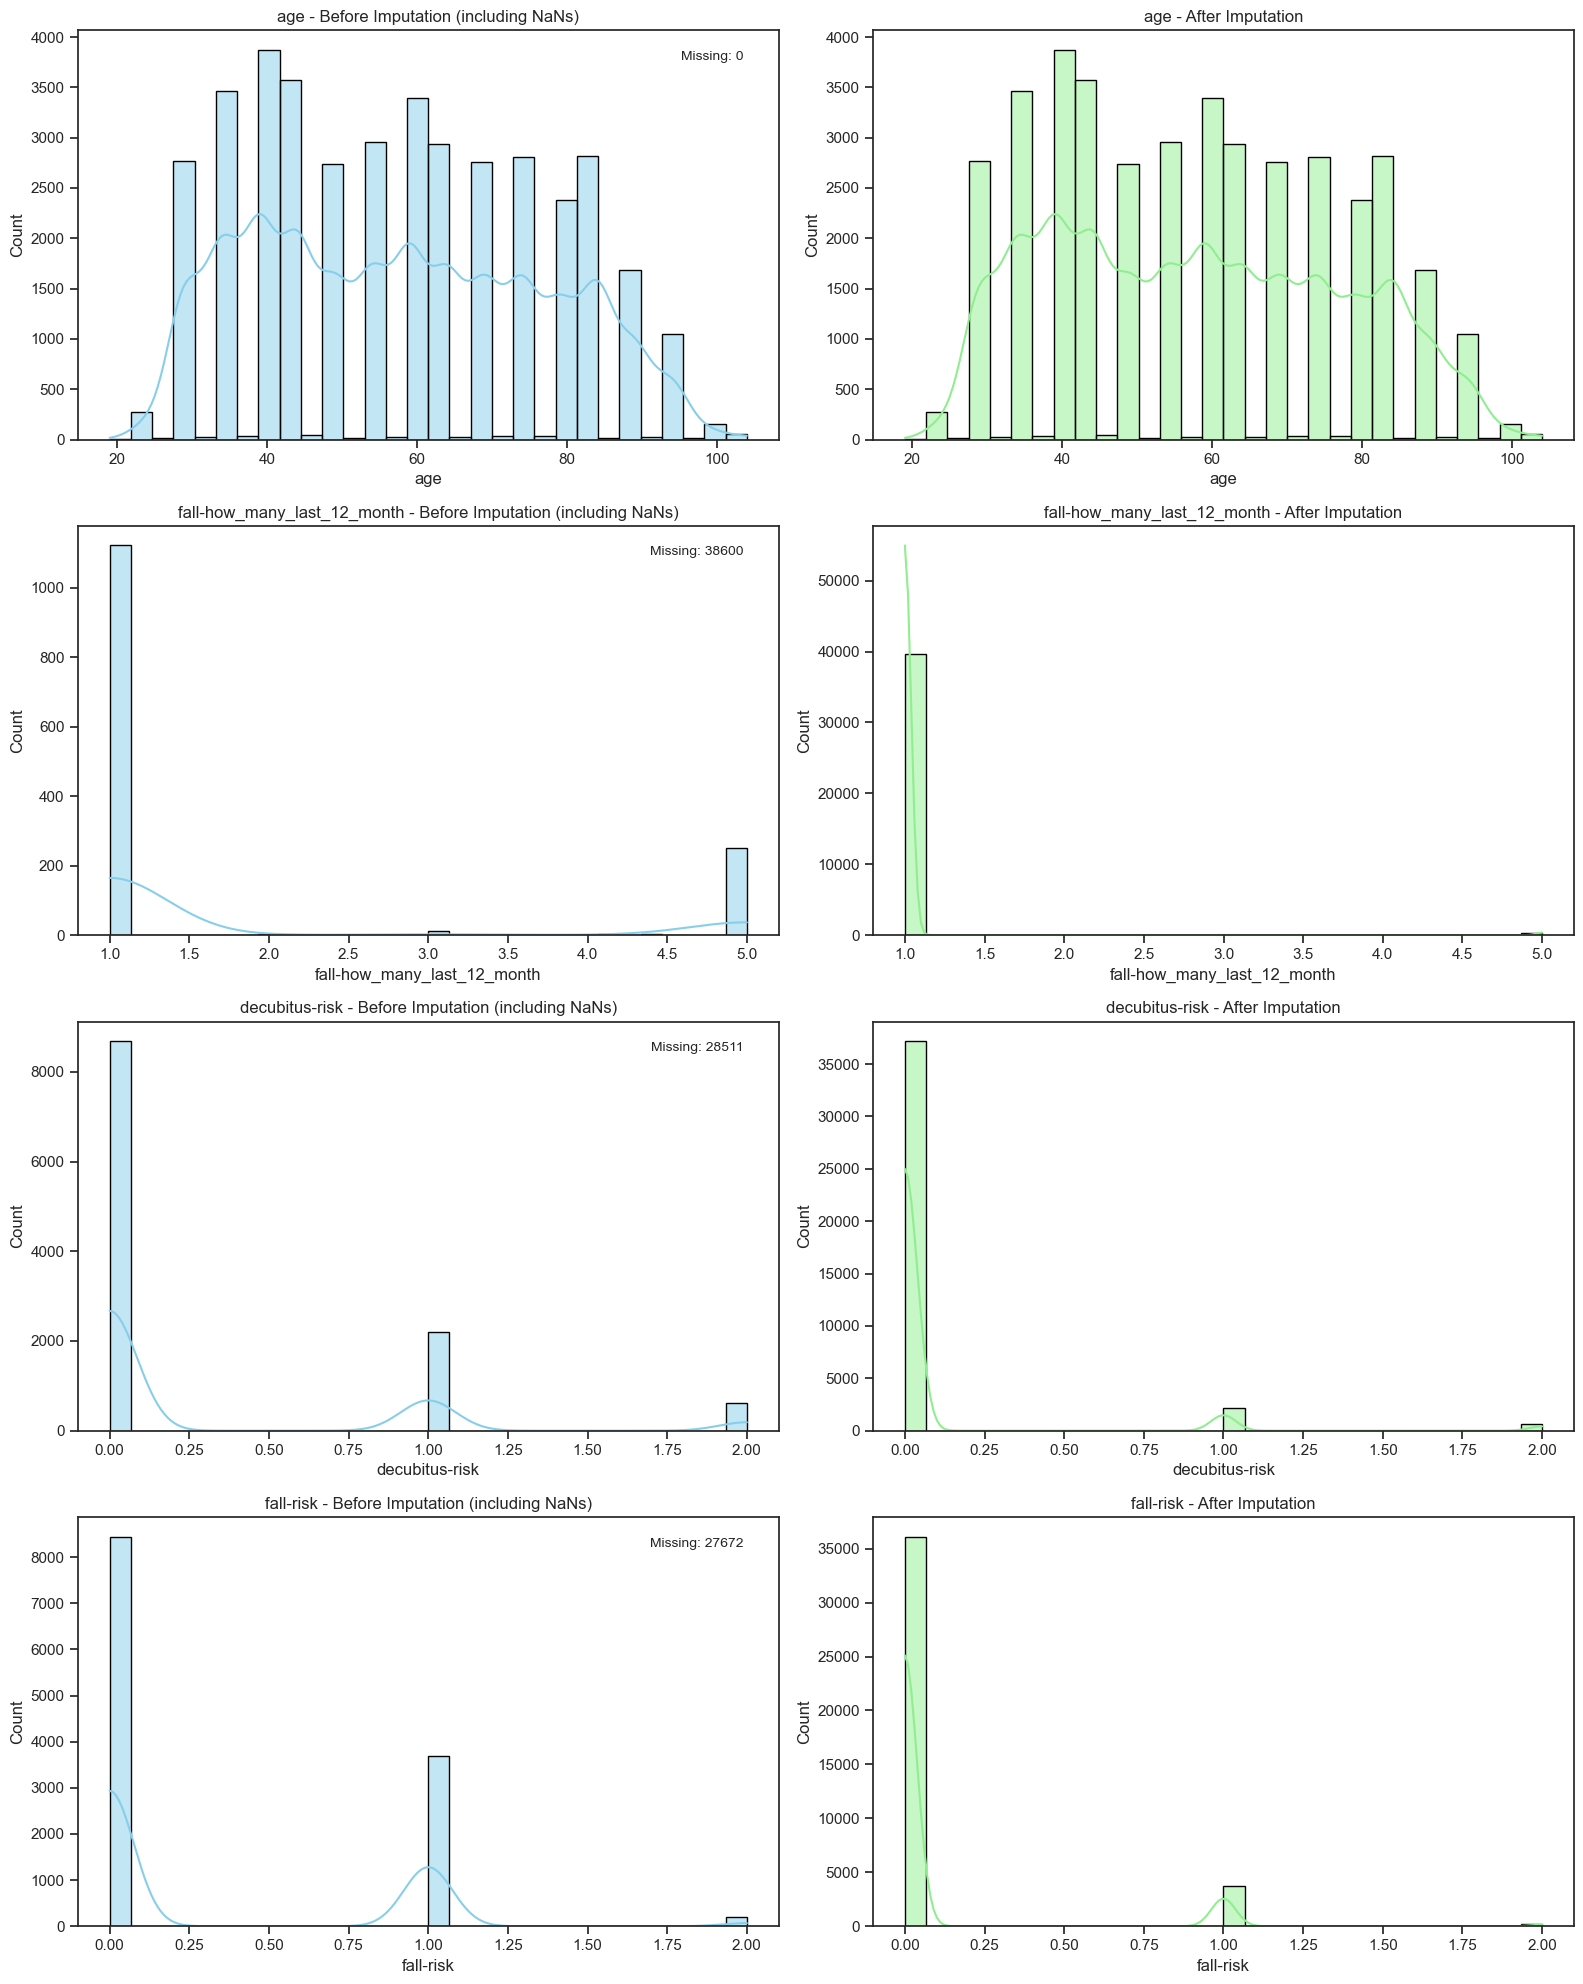

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


# Set up the plot
plt.figure(figsize=(16, 5 * len(numerical_vars)))

for i, col in enumerate(numerical_vars):
    plt.subplot(len(numerical_vars), 2, 2*i + 1)
    sns.histplot(df_before[col], bins=30, kde=True, color="skyblue", edgecolor="black")
    plt.title(f'{col} - Before Imputation (including NaNs)')
    plt.xlabel(col)
    plt.ylabel('Count')

    # Show number of missing values
    na_count = df_before[col].isna().sum()
    plt.annotate(f'Missing: {na_count}', xy=(0.95, 0.95), xycoords='axes fraction',
                 ha='right', va='top', fontsize=10, bbox=dict(boxstyle='round', fc='white'))

    plt.subplot(len(numerical_vars), 2, 2*i + 2)
    sns.histplot(df[col], bins=30, kde=True, color="lightgreen", edgecolor="black")
    plt.title(f'{col} - After Imputation')
    plt.xlabel(col)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()


In [19]:
# Loop through categorical variables and print unique values and their distributions
for col in categorical_vars:
	print(f"Column: {col}")
	print("Unique Values and Counts:")
	print(df[col].value_counts(dropna=False))
	print("\n")

Column: procedure
Unique Values and Counts:
procedure
0       17789
1-10     1198
1-20      620
1-22      396
3-84      332
3-90      308
1-24      307
3-82      300
3-99      279
3-80      278
3-76      270
5-02      264
5-01      240
1-26      236
9-98      232
5-03      232
9-70      225
9-61      215
3-75      202
9-60      196
1-27      194
1-31      189
9-64      185
5-04      180
5-05      178
9-41      177
9-50      176
9-28      165
9-32      163
5-06      158
1-33      156
3-73      155
9-40      153
9-20      150
5-09      145
9-26      142
1-42      140
5-07      135
8-98      134
8-92      134
1-41      130
8-93      120
8-81      120
8-97      119
8-80      118
1-40      118
5-08      117
8-91      117
1-43      115
8-83      111
3-72      111
8-63      111
5-11      110
8-82      109
8-60      108
5-10      108
8-70      108
3-70      107
8-64      104
8-85      103
1-47      101
8-77      100
8-53      100
8-90       98
8-55       97
5-13       97
8-71       96
5-23    

### CATEGORICAL VARIABLES

In [20]:
# Calculate the percentage of missing values for categorical variables
categorical_na_percentage = df[categorical_vars].isna().mean() * 100

# Print the result
print("Percentage of missing values for categorical variables:")
print(categorical_na_percentage)


Percentage of missing values for categorical variables:
procedure              0.0000
diagnosis              0.0000
bed_mobility-jones    93.9825
transfer              92.4850
walk-jones            89.0675
sex                    0.0000
dtype: float64


### 🧾 Handling Missing Values and Encoding for Categorical Variables

| Column               | # Unique Values | Missing % | Imputation Strategy         | Encoding Strategy             | Notes                                                                 |
|----------------------|------------------|------------|-----------------------------|-------------------------------|-----------------------------------------------------------------------|
| `procedure`          | ~250+            | Low        | Fill with `'Unknown'`       | Frequency or Target Encoding  | Too many categories for one-hot; consider grouping rare ones.        |
| `diagnosis`          | 3,345            | Low        | Fill with `'Unknown'`       | Target Encoding or Embedding  | Very high cardinality — one-hot not practical.                       |
| `bed_mobility-jones` | 6                | ~93%       | Fill with `'Missing'`       | One-hot or Ordinal Encoding   | Small number of categories — treat missing as valid category.        |
| `transfer`           | 6                | ~92%       | Fill with `'Missing'`       | One-hot or Ordinal Encoding   | Same as above.                                                        |
| `walk-jones`         | 6                | ~89%       | Fill with `'Missing'`       | One-hot or Ordinal Encoding   | Same as above.                                                        |
| `sex`                | 2 (0, 1)         | None       | —                           | Use as-is                     | Already binary — no transformation needed.                           |


In [21]:
# df['procedure'] = df['procedure'].fillna('Unknown')
# df = pd.get_dummies(df, columns=['procedure'])


# df['diagnosis'] = df['diagnosis'].fillna('Unknown')
# df = pd.get_dummies(df, columns=['diagnosis'])


# df['transfer'] = df['transfer'].fillna('Unknown')
# df = pd.get_dummies(df, columns=['transfer'])

# df['bed_mobility-jones'] = df['bed_mobility-jones'].fillna('Unknown')
# df = pd.get_dummies(df, columns=['bed_mobility-jones'])

# # df['decubitus-risk'] = df['decubitus-risk'].fillna('Unknown')
# # df = pd.get_dummies(df, columns=['decubitus-risk'])

# df['fall-risk'] = df['fall-risk'].fillna('Unknown')
# df = pd.get_dummies(df, columns=['fall-risk'])


## BAD IDEA? Create length=3609 columns

In [ ]:
# import prince

# df_backup = df.copy

# target = 'fallen'
# id_var = 'id'

# # Create feature matrix X (drop target + ID)
# X = df.drop(columns=[target, id_var])


# # Force numerical columns to float64 (not nullable Int64)
# for col in numerical_vars:
#     X[col] = pd.to_numeric(X[col], errors='coerce').astype(float)  # 💥 this line is key
#     print(f"{col}: {X[col].dtype}")



# for col in categorical_vars + bool_vars:
#     X[col] = X[col].astype(str).fillna('missing')

# # ✅ Step 3: Run FAMD
# famd = prince.FAMD(n_components=5, random_state=42)
# X_famd = famd.fit_transform(X)



age: float64
fall-how_many_last_12_month: float64
decubitus-risk: float64
fall-risk: float64


In [ ]:
# print(X_famd.head())
# print(X_famd.shape)


component      0          1         2         3         4   
0          -4.104265  2.125940  2.860141 -1.827122  3.901252
1          -3.591674  2.465551  4.105517  1.774011  5.622685
2          -2.599837  1.449773 -2.829036  0.435444  7.530817
3          11.990689  5.275426 -5.387266 -3.417727 -2.316239
4          -2.888135 -0.072971  2.698828  6.295551  3.452066
(40000, 5)


In [ ]:
# famd.column_correlations(X)


NotImplementedError: FAMD inherits from PCA, but this method is not implemented yet

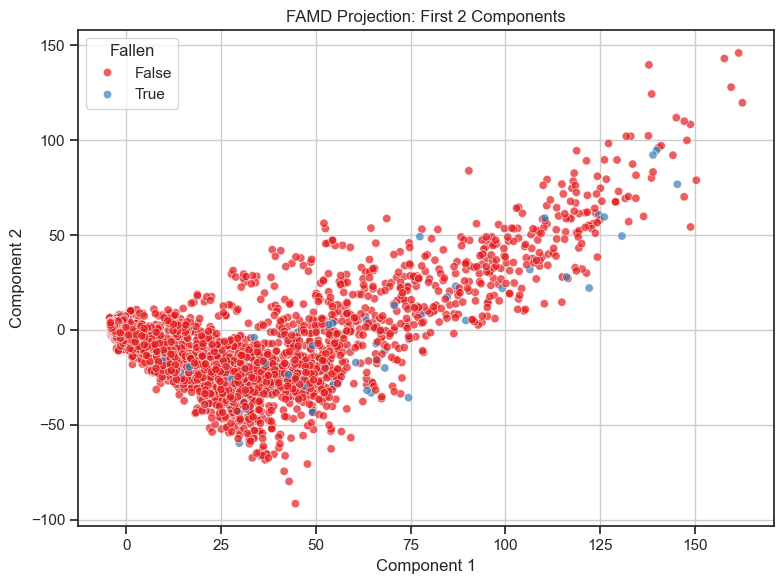

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Add the target back for coloring
# X_famd['fallen'] = df['fallen'].values

# # Plot
# plt.figure(figsize=(8, 6))
# sns.scatterplot(
#     data=X_famd,
#     x=0, y=1,
#     hue='fallen',
#     palette='Set1',
#     alpha=0.7
# )
# plt.title('FAMD Projection: First 2 Components')
# plt.xlabel('Component 1')
# plt.ylabel('Component 2')
# plt.legend(title='Fallen')
# plt.grid(True)
# plt.tight_layout()
# plt.show()


### BOOLEAN VARIABLE

In [ ]:
# Calculate the percentage of missing values for boolean variables
bool_na_percentage = df[bool_vars].isna().mean() * 100

# Print the result
print("Percentage of missing values for boolean variables:")
print(bool_na_percentage)

Percentage of missing values for boolean variables:
fallen                                               0.0000
c_zriserh1                                           0.0000
decubitus-admission                                 76.5025
decubitus-at_the_moment                             76.0025
bed_mobility-impairment                             72.1800
bed_mobility-skin_condition                         96.1175
transfer-impairment                                 71.4700
medical_items                                       73.0075
medical_items-arm_or_leg_splint                      0.0000
medical_items-A_V_system                             0.0000
medical_items-plaster_or_neck_brace                  0.0000
medical_items-compression_stocking                   0.0000
medical_items-ventilation_mask                       0.0000
medical_items-O2_glasses                             0.0000
medical_items-orthesis                               0.0000
medical_items-prosthesis                        

### 🧾 Strategy for Handling Boolean Variables with Missing Values

In [ ]:
# TODO: Add _missing column for important vars?

In [ ]:
# def encode_boolean_vars_with_missing(df, boolean_vars):
#     """
#     Handles boolean variables with missing values:
#     - Fills missing values with 'Missing'
#     - Converts to category dtype
#     - Applies one-hot encoding (including a 'Missing' column)

#     Parameters:
#         df (pd.DataFrame): The input DataFrame
#         boolean_vars (list): List of column names with boolean values

#     Returns:
#         pd.DataFrame: Transformed DataFrame with one-hot encoded boolean columns
#     """
#     df = df.copy()  # avoid modifying original

#     for col in boolean_vars:
#         # Convert to object (for NA + bool handling)
#         df[col] = df[col].astype(object)
#         # Replace NaNs with a placeholder
#         df[col] = df[col].fillna('Missing')
#         # Convert to categorical (better for get_dummies)
#         df[col] = df[col].astype('category')

#     # One-hot encode with all levels (True, False, Missing)
#     df = pd.get_dummies(df, columns=boolean_vars, drop_first=False)

#     return df

# df_encoded = encode_boolean_vars_with_missing(df, bool_vars)


In [ ]:
# print([col for col in df_encoded.columns if any(var in col for var in bool_vars)])


In [ ]:
# df_encoded.columns.size

## DIMENSIONALITY REDUCTION

### PCA FOR NUMERICAL VARIABLES

In [27]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_num = df[numerical_vars].copy()
X_num = StandardScaler().fit_transform(X_num)

pca = PCA(n_components=3)
X_pca = pd.DataFrame(pca.fit_transform(X_num), columns=['pca1', 'pca2', 'pca3'])


### MCA FOR CATEGORICAL AND BOOL VARIABLES

In [29]:
X_cat = df[categorical_vars + bool_vars].copy()
for col in X_cat.columns:
    X_cat[col] = X_cat[col].astype(str).fillna('missing')

import prince
mca = prince.MCA(n_components=3, random_state=42)
X_mca = mca.fit_transform(X_cat)
X_mca.columns = ['mca1', 'mca2', 'mca3']


### COMBINING PCA AND MCA RESULT

In [30]:
X_combined = pd.concat([X_pca, X_mca], axis=1)
X_combined['fallen'] = df['fallen'].values


### (Optional): Compare With Gower + MDS/UMAP



In [35]:
import gower
from sklearn.manifold import MDS

# Make a copy to avoid modifying the original
X_gower = df[numerical_vars + categorical_vars + bool_vars].copy()

# Convert numerical columns to float64 (standard + safe for missing values)
for col in numerical_vars:
    X_gower[col] = pd.to_numeric(X_gower[col], errors='coerce').astype(float)

# Convert categorical/binary to string (so Gower treats them as categorical)
for col in categorical_vars + bool_vars:
    X_gower[col] = X_gower[col].astype(str).fillna('missing')

gower_matrix = gower.gower_matrix(X_gower)

mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
X_mds = pd.DataFrame(mds.fit_transform(gower_matrix), columns=['mds1', 'mds2'])
X_mds['fallen'] = df['fallen'].values


: 

### GET IMPORTANCE

In [ ]:
loadings = pd.DataFrame(
    np.abs(pca.components_.T),
    index=numerical_vars,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)]
)

# Sum across components to get overall influence
loadings['overall'] = loadings.sum(axis=1)
print("🔢 Top PCA numerical variables:")
print(loadings['overall'].sort_values(ascending=False).head(10))

### 2. Outlier Detection and Handling

Outliers can skew the analysis, especially in medical data. Our approach to handle outliers includes:
- **Visualization:** Using boxplots and histograms to visually inspect the distribution of numeric variables.
- **Statistical Methods:** Using the Interquartile Range (IQR) to flag outliers. Values below Q1 - 1.5*IQR or above Q3 + 1.5*IQR will be flagged as potential outliers.
- **Handling Strategy:** Depending on the variable and the context, we may:
  - Cap the outliers at the boundary values
  - Remove the data points if they are likely errors
  - Use transformation methods (e.g., log transformation) if the distribution is highly skewed

The code below demonstrates the IQR-based detection for a sample numeric column (e.g., `age`). You should replicate or extend this approach for other numeric variables.


In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# def visualize_outliers(df, column):
#     """
#     Creates a boxplot and histogram for a numeric column.
#     """
#     fig, axes = plt.subplots(1, 2, figsize=(14, 5))
#     sns.boxplot(y=df[column], ax=axes[0])
#     axes[0].set_title(f'Boxplot of {column}')

#     sns.histplot(df[column], kde=True, ax=axes[1])
#     axes[1].set_title(f'Histogram of {column}')

#     plt.tight_layout()
#     plt.show()


In [ ]:
# def detect_outliers_iqr(series):
#     """
#     Returns lower and upper bounds, and a mask for outliers in the Series.
#     """
#     Q1 = series.quantile(0.25)
#     Q3 = series.quantile(0.75)
#     IQR = Q3 - Q1

#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
#     outlier_mask = (series < lower_bound) | (series > upper_bound)

#     return lower_bound, upper_bound, outlier_mask


##### Outlier Handling: What’s the Difference?
Capping (Winsorization)	
- Replaces extreme outliers with a threshold (e.g. Q1 - 1.5IQR or Q3 + 1.5IQR)	
- Preserves all rows, reduces impact of outliers	
- Still keeps modified outlier values in dataset	
- When data is mostly valid but has extreme values

Removing
- Deletes rows that contain outlier values	
- Removes truly erroneous data	
- Loses information, can reduce sample size	
- When outliers are likely due to data entry error

Transforming	
- Applies a function (e.g., log, sqrt) to reduce skewness	
- Keeps all data, handles skew	
- Can complicate interpretability	
- When distribution is heavily skewed (e.g. income, lab results)

In [ ]:
# def handle_outliers(df, column, method="cap"):
#     """
#     Detects and handles outliers in a column using IQR.

#     Parameters:
#     - df: DataFrame
#     - column: str, column to process
#     - method: str, one of ["cap", "remove", "log"]

#     Returns:
#     - Modified DataFrame
#     """
#     lower, upper, mask = detect_outliers_iqr(df[column])
#     if method == "cap":
#         df[column] = df[column].clip(lower, upper)
#     elif method == "remove":
#         df = df[~mask]
#     elif method == "log":
#         df[column] = df[column].apply(lambda x: np.log1p(x) if x > 0 else x)
#     else:
#         raise ValueError("Method must be one of ['cap', 'remove', 'log']")

#     print(f"{mask.sum()} outliers handled in '{column}' using '{method}' method.")
#     return df


In [ ]:
# for col in numerical_vars:
#     plt.figure(figsize=(12, 4))

#     plt.subplot(1, 2, 1)
#     sns.boxplot(x=df[col])
#     plt.title(f"Boxplot of {col}")

#     plt.subplot(1, 2, 2)
#     sns.histplot(df[col], kde=True)
#     plt.title(f"Histogram of {col}")

#     plt.tight_layout()
#     plt.show()

In [ ]:
# # |Skew| < 0.5 → Roughly symmetric → capping or removing is okay.
# # |Skew| ≥ 1 → Highly skewed → transformation might help.

# df[numerical_vars].skew().sort_values()


In [ ]:
# def outlier_proportion(series):
#     Q1 = series.quantile(0.25)
#     Q3 = series.quantile(0.75)
#     IQR = Q3 - Q1
#     lower = Q1 - 1.5 * IQR
#     upper = Q3 + 1.5 * IQR
#     return ((series < lower) | (series > upper)).mean()

# outlier_stats = {col: outlier_proportion(df[col].dropna()) for col in numerical_vars}
# outlier_stats = pd.Series(outlier_stats).sort_values(ascending=False)
# print(outlier_stats)


| Feature Type | Skewness | % Outliers | Suggested Method                                       |
|--------------|----------|------------|--------------------------------------------------------|
| Symmetric    | Low      | < 5%       | Probably safe to **cap** or **remove**                |
| Symmetric    | Low      | > 20%      | Consider **capping** to retain data                   |
| Skewed       | High     | > 10%      | Try **log / sqrt transform**, or **cap after transform** |
| Any          | Any      | Clearly invalid values (e.g. `age > 120`) | **Remove** those values                |


In [ ]:
# for col in numerical_vars:
#     df = handle_outliers(df, col, method='cap')

Question: Regarding outliers in the dataset (not found until now)?

# Section 2: Data Exploration & Relationships

#### DIMENSIONALITY REDUCTION USING FAMD (Factor Analysis of Mixed Data)

Why: Our data is a mix of numerical, categorical, and binary.

FAMD combines:
- PCA for numerical features
- MCA for categorical features

It treats all variable types appropriately and returns components that represent all of them.


## Correlation analytics
- Heatmap
- Rule mining: Attecendent -> Consequence



## Visualization of meaningful insights
- Plotting age group -> Fall (depends on the previous result)

## Feature engineering
- Summarize various features/columns that are connected to each other -> Possibly stronger prediction

# Section 3: Model Development

## Logistic Regression (simple model)

## Neural Network (complex model)

# Section 4: Model Evaluation & Interpretation

## Strength & Weakness
- Parameters that influence the prediction result

## Stakeholder etc.
- Which model is preferable in which scenario/for which stakeholder


## Actionable insights